# Deepfake Detection with CNNs

by

Name: *Ventsislav V. Dimitrov*  
SoftUni username: *nechoventsi*

Deep learining models are getting really good at generating fake human faces. This constitutes a real problem for various services, like automatic ID verification (i.e. for banking apps), fake persona representation on social media, deepfake videos, catfishing, etc.

With this model, we're aiming to test a Transfer Learning strategy for the detection and classification of real and fake human faces.

The dataset used is a collection of human faces, 70 000 of which are real photographs of people (the [Flickr- Faces-HQ](https://github.com/NVlabs/ffhq-dataset) (FFHQ) dataset collected by Nvidia [1]), while the other 70 000 are GAN-generated fake human faces. The dataset used in the current work is [available on Kaggle](https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces) [2] and is pre-split into train, validation and test sets.

## 1. Imports

In [1]:
import os
import glob
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

## 2. Data

In [2]:
# Directory containing the data:
data_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"

# Define the classes as variables:
data_classes = os.listdir(os.path.join(data_path, "train"))
data_classes

['fake', 'real']

In [3]:
data_dict = {"img_path":[],"label":[],"part":[]}

for part in os.listdir(data_path):
    for label in os.listdir(data_path + "/" + part):
        for img in glob.glob(data_path + part + "/" + label + "/" + "*.jpg"):
            data_dict["img_path"].append(img)
            data_dict["label"].append(label)
            data_dict["part"].append(part)
df = pd.DataFrame(data_dict)

In [4]:
df.head()

,img_path,label,part
0,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
1,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
2,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
3,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
4,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid


In [5]:
# Classes counts:
df["label"].value_counts()

fake    70000
real    70000
Name: label, dtype: int64

In [6]:
# Train, validation, test counts:
df["part"].value_counts()

train    100000
valid     20000
test      20000
Name: part, dtype: int64

Sample `fake` image:


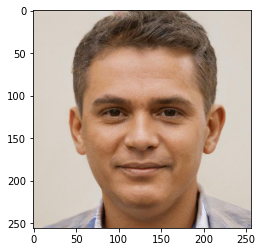


Sample `real` image:


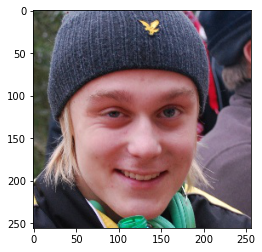

In [7]:
# Plot a fake face:
print(f"Sample `{data_classes[0]}` image:")
plt.imshow(load_img(os.path.join(data_path + "train", data_classes[0], os.listdir(data_path + "train/" + data_classes[0])[0])))
plt.show()

# Plot a real face:
print(f"\nSample `{data_classes[1]}` image:")
plt.imshow(load_img(os.path.join(data_path + "train", data_classes[1], os.listdir(data_path + "train/" + data_classes[1])[0])))
plt.show()

In [8]:
# Load a sample fake face image:
sample_fake_img  = load_img(os.path.join(data_path + "train", data_classes[0], os.listdir(data_path + "train/" + data_classes[0])[0]))
# Convert the image into array representation to check dimensions:
sample_fake_array = img_to_array(sample_fake_img)
# Show the shape:
print(f"Shape of `{data_classes[0]}` images: {sample_fake_array.shape}")

# Load a sample real face image:
sample_real_img  = load_img(os.path.join(data_path + "train", data_classes[1], os.listdir(data_path + "train/" + data_classes[1])[0]))
# Convert the image into array representation to check dimensions:
sample_real_array = img_to_array(sample_real_img)
# Show the shape:
print(f"Shape of `{data_classes[1]}` images: {sample_real_array.shape}")

Shape of `fake` images: (256, 256, 3)
Shape of `real` images: (256, 256, 3)


## 3. Construct dataset

In [9]:
# Define a data generator function that will limit repetitive code, 
# as we have data pre-split into train, validation and test sets.
def get_data_generator(data_directory, class_mode, batch_size=32, resize_to=(256, 256), preprocessing_function=None):
    """Create a data generator from a directory containing images.

    Params:
    -------
    data_directory :: string  
        The path containing the image data  
    class_mode :: str  
        One of 'categorical', 'binary', 'sparse', 'input', or `None`.  
        Determines the type of label arrays that are returned:  
            - 'categorical' will be 2D one-hot encoded labels;  
            - 'binary' will be 1D binary labels;  
            - 'sparse' will be 1D integer labels;  
            - 'input' will be images identical to input images (mainly used to work with autoencoders).  
    batch_size :: int  
        Custom batch size. Default: 32  
    resize_to :: tuple  
        New image size. Default: (256, 256)  
    preprocessing_function :: function  
        The images pre-processing function to use for the data generator. Default: `None`

    Returns:
    --------
    data_generator :: keras DirectoryIterator  
        The iterator object to load the data from directory"""

    # Instantiate the generator, normalise pixel values:
    img_generator = ImageDataGenerator(rescale=1./255,
                                       preprocessing_function=preprocessing_function)

    # Generate data. Set batch size, class mode and image size.
    # Don't forget seed for reproducibility:
    data_generator = img_generator.flow_from_directory(directory=data_directory,
                                                       batch_size=batch_size,
                                                       class_mode=class_mode,
                                                       target_size=resize_to,
                                                       seed=666)

    # Return the generated data:
    return data_generator

In [ ]:
# Define batch size:
BATCH_SIZE = 32

In [10]:
# Create the training set generator:
train_generator = get_data_generator(data_directory=data_path+"train/",
                                     class_mode="binary",
                                     batch_size=BATCH_SIZE,
                                     resize_to=(224, 224))
# Create the validation set generator:
val_generator = get_data_generator(data_directory=data_path+"valid/",
                                   class_mode="binary",
                                   batch_size=BATCH_SIZE,
                                   resize_to=(224, 224))
# Create the test set generator:
test_generator = get_data_generator(data_directory=data_path+"test/",
                                    class_mode="binary",
                                    batch_size=1,
                                    resize_to=(224, 224))

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## 4. Building a Convolutional Neural Network for image classification

Following is a custom CNN build and test for the successfull classification and detection of fake human faces.

In [11]:
# Define a funtion to build a custom CNN:
def build_model(input_shape, optimizer, conv_blocks=3, dropout_rate=0.5, conv_dropout=False):
    """Construct a Convolutional Neural Network with specified layers 
    and options.

    Params:
    -------
    input_shape :: tuple  
        A tuple in the form of (256, 256, 3) for the shape of 
        the input image, with number of channels  
    optimizer :: keras optimizer  
        The chosen optimizer for this network  
    conv_blocks :: int  
        Number of convolutional blocks for the CNN to have. 
        The first Conv2D layer has 32 inputs, the following 
        inputs grow x2. Each Conv2D layer is followed by a 
        MaxPooling2D and (optionally) by a Dropout layer. Default: 3  
    dropout_rate :: float  
        The rate for the dropout layers, between 0 and 1  
    conv_dropout :: boolean  
        Decide if the convolutional block should end with a 
        Dropout layer. Default: False

    Returns:
    --------
    model :: keras model object  
        The compiled model object to train"""

    # Instantiate the model and add input layer:
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Add convolutional block(s):
    for cb in range(conv_blocks):
        model.add(Conv2D(32 * (2**cb), (3, 3), activation="relu"))
        model.add(MaxPooling2D((2, 2)))
        if conv_dropout == True:
            model.add(Dropout(dropout_rate))

    # Flatten convolutional block(s) output and pass it to Dense layer:
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))

    # Compile model:
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    # Return:
    return model

### 4.1. Convolutional Neural Network with 3 convolutional blocks and no dropout within them

As an optimiser, we will use the robust Adam optimiser [3], which has proven useful for many different tasks.

In [12]:
CNN_no_drop = build_model(input_shape=(224, 224, 3), 
                          optimizer=Adam(learning_rate=0.001), 
                          conv_blocks=3, 
                          dropout_rate=0.5, 
                          conv_dropout=False)

2023-02-02 07:36:13.959848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 07:36:13.960801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 07:36:14.138492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 07:36:14.139318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 07:36:14.140096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [13]:
# Model summary:
CNN_no_drop.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [14]:
# Calculate the number of steps per epoch:
train_steps = 100000 // BATCH_SIZE
val_steps = 20000 // BATCH_SIZE

# Instantiate callbacks:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# Time the training:
start_time = time.time()

# Fit model with generator:
CNN_no_drop_history = CNN_no_drop.fit(train_generator,
                                      steps_per_epoch=train_steps,
                                      validation_data=val_generator,
                                      validation_steps=val_steps,
                                      epochs=20,
                                      callbacks=[early_stopping])

# Time the training:
end_time = time.time()
print(f"Training time: {round((end_time - start_time) / 60)} minutes.")

2023-02-02 07:36:19.342467: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-02-02 07:36:21.894805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3125/3125 [==============================] - 1286s 407ms/step - loss: 0.5276 - accuracy: 0.7296 - val_loss: 0.4124 - val_accuracy: 0.8099
Epoch 2/20
3125/3125 [==============================] - 500s 160ms/step - loss: 0.3091 - accuracy: 0.8680 - val_loss: 0.2530 - val_accuracy: 0.8992
Epoch 3/20
3125/3125 [==============================] - 460s 147ms/step - loss: 0.1987 - accuracy: 0.9205 - val_loss: 0.1902 - val_accuracy: 0.9261
Epoch 4/20
3125/3125 [==============================] - 458s 146ms/step - loss: 0.1305 - accuracy: 0.9491 - val_loss: 0.1688 - val_accuracy: 0.9381
Epoch 5/20
3125/3125 [==============================] - 463s 148ms/step - loss: 0.0926 - accuracy: 0.9654 - val_loss: 0.1862 - val_accuracy: 0.9406
Epoch 6/20
3125/3125 [==============================] - 465s 149ms/step - loss: 0.0728 - accuracy: 0.9737 - val_loss: 0.1839 - val_accuracy: 0.9375
Epoch 7/20
3125/3125 [==============================] - 465s 149ms/step - loss: 0.0601 - accuracy: 0.9783 - val_loss: 0.18

#### 4.1.1. Save the model for future reference and/or use

In [15]:
# Save the model object:
CNN_no_drop.save("CNN_model_no_dropout.h5", save_format="h5")
# # Save the history to a DataFrame:
CNN_no_drop_history_df = pd.DataFrame(CNN_no_drop_history.history)
# # Save the history DataFrame to a file:
CNN_no_drop_history_df.to_csv("CNN_model_no_dropout_history.csv", index=False)

#### 4.1.2. Model performance exploration

Following is a simple exploration of the model performance, along with an evaluation on the testing part of the dataset.

In [16]:
def plot_metric(history, metric):
    """Plot the chosen metric curves for eaasy visualisation.

    Params:
    -------
    history :: keras History object  
        The information for events during training  
    metric :: str  
        The metric of choice to plot"""

    # Train metric:
    train_metric = history.history[metric]
    # Validation metric:
    val_metric = history.history["val_" + metric]
    # The range of epochs for the X axis:
    epochs = range(len(train_metric))
    # Plot the epochs on the X axis vs. the metric on the Y axis:
    plt.plot(epochs, train_metric)
    plt.plot(epochs, val_metric)
    # Title, labels, legend:
    plt.title("Training and validation " + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, "val_" + metric])
    # Show plot:
    plt.show()

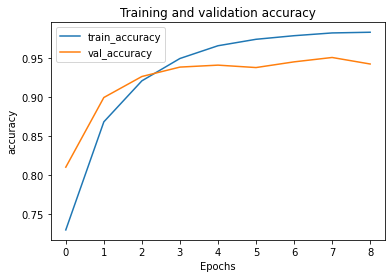

In [17]:
# Plot training and validation accuracy curves:
plot_metric(history=CNN_no_drop_history, metric="accuracy")

In [18]:
# Run model.predict on the unseen test data:
y_pred = CNN_no_drop.predict(test_generator)
y_test = test_generator.classes

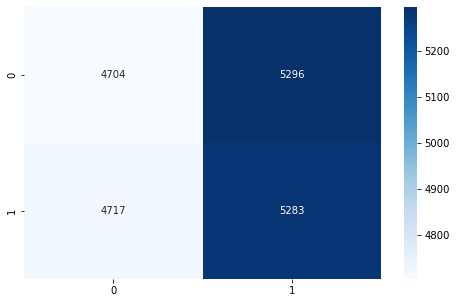

In [19]:
# Show a confusion matrix for the test predictions:
plt.figure(figsize = (8, 5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot=True, fmt="d", cmap = "Blues")
plt.show()

In [20]:
# Check Area Under the Curve score:
print("ROC-AUC Score:", round(metrics.roc_auc_score(y_test, y_pred), 2))
# Check average precision score:
print("AP Score:", round(metrics.average_precision_score(y_test, y_pred), 2))

# Show classification report:
print("\n", metrics.classification_report(y_test, y_pred > 0.5))

ROC-AUC Score: 0.5
AP Score: 0.5

               precision    recall  f1-score   support

           0       0.50      0.47      0.48     10000
           1       0.50      0.53      0.51     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



The network doesn't seem to work. Metrics on the validation set look OK, but when predicting on the test set, the accuracy is 50%. It seems the CNN is overfitting and isn't able to generalise the knowledge.

As a second step, we will test the same architecture, but this time we will add dropout layers after each convolutional block. Lets see if this improves the performance.

### 4.2. Convolutional Neural Network with 3 convolutional blocks with dropout within them

In [21]:
CNN_with_drop = build_model(input_shape=(224, 224, 3), 
                            optimizer=Adam(learning_rate=0.001), 
                            conv_blocks=3, 
                            dropout_rate=0.5, 
                            conv_dropout=True)

In [22]:
CNN_with_drop.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 128)      

In [23]:
# Time the training:
start_time = time.time()

# Fit model with generator:
CNN_with_drop_history = CNN_with_drop.fit(train_generator,
                                          steps_per_epoch=train_steps,
                                          validation_data=val_generator,
                                          validation_steps=val_steps,
                                          epochs=20,
                                          callbacks=[early_stopping])

# Time the training:
end_time = time.time()
print(f"Training time: {round((end_time - start_time) / 60)} minutes.")

Epoch 1/20
3125/3125 [==============================] - 587s 187ms/step - loss: 0.6728 - accuracy: 0.5994 - val_loss: 0.5949 - val_accuracy: 0.7052
Epoch 2/20
3125/3125 [==============================] - 496s 159ms/step - loss: 0.5208 - accuracy: 0.7439 - val_loss: 0.5169 - val_accuracy: 0.7509
Epoch 3/20
3125/3125 [==============================] - 475s 152ms/step - loss: 0.4399 - accuracy: 0.7971 - val_loss: 0.4116 - val_accuracy: 0.8230
Epoch 4/20
3125/3125 [==============================] - 494s 158ms/step - loss: 0.3882 - accuracy: 0.8273 - val_loss: 0.3895 - val_accuracy: 0.8234
Epoch 5/20
3125/3125 [==============================] - 470s 150ms/step - loss: 0.3456 - accuracy: 0.8505 - val_loss: 0.3758 - val_accuracy: 0.8292
Epoch 6/20
3125/3125 [==============================] - 532s 170ms/step - loss: 0.3152 - accuracy: 0.8662 - val_loss: 0.3547 - val_accuracy: 0.8468
Epoch 7/20
3125/3125 [==============================] - 536s 171ms/step - loss: 0.2909 - accuracy: 0.8784 - val_

#### 4.2.1. Save the model for future reference and/or use

In [24]:
# Save the model object:
CNN_with_drop.save("CNN_model_with_dropout.h5", save_format="h5")
# # Save the history to a DataFrame:
CNN_with_drop_history_df = pd.DataFrame(CNN_with_drop_history.history)
# # Save the history DataFrame to a file:
CNN_with_drop_history_df.to_csv("CNN_model_with_dropout_history.csv", index=False)

#### 4.2.2. Model performance exploration

Following, as for the feature extraction step above, is a simple exploration of the model performance, along with an evaluation on the testing part of the dataset.

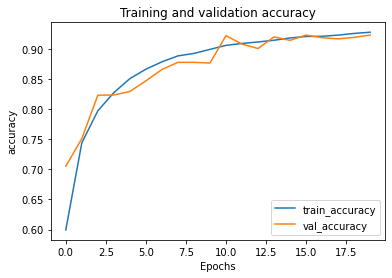

In [25]:
# Plot training and validation accuracy curves:
plot_metric(history=CNN_with_drop_history, metric="accuracy")

In [26]:
# Run model.predict on the unseen test data:
y_pred_new = CNN_with_drop.predict(test_generator)
y_test_new = test_generator.classes

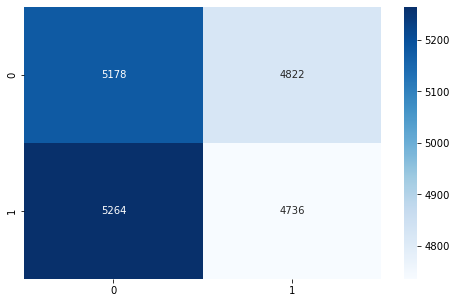

In [27]:
# Show a confusion matrix for the test predictions:
plt.figure(figsize = (8, 5))
sns.heatmap(metrics.confusion_matrix(y_test_new, y_pred_new.round()), annot=True, fmt="d", cmap = "Blues")
plt.show()

In [28]:
# Check Area Under the Curve score:
print("ROC-AUC Score:", round(metrics.roc_auc_score(y_test_new, y_pred_new), 2))
# Check average precision score:
print("AP Score:", round(metrics.average_precision_score(y_test_new, y_pred_new), 2))

# Show classification report:
print("\n", metrics.classification_report(y_test_new, y_pred_new > 0.5))

ROC-AUC Score: 0.5
AP Score: 0.5

               precision    recall  f1-score   support

           0       0.50      0.52      0.51     10000
           1       0.50      0.47      0.48     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



There is basically no improvement in the performance of the second CNN architecture.

## Conclusions

The CNN architecture that we have here chosen doesn't seem capable of accurately predicting which faces are real and which are fake. It may be that the network is too shallow and/or hyperparameter tuning is needed to get the CNN to learn. One other possibility may be that the fake faces are too similar to the real ones and a more complex architecture is needed to distinguish between them.

## References

- [1] T. Karras, S. Laine and T. Aila, "A Style-Based Generator Architecture for Generative Adversarial Networks," 2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Long Beach, CA, USA, 2019, pp. 4396-4405, doi: 10.1109/CVPR.2019.00453.
- [2] https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
- [3] Kingma, Diederik P. and Jimmy Ba. “Adam: A Method for Stochastic Optimization.” CoRR abs/1412.6980 (2014)